# Sine generation

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import upfirdn

<Figure size 432x288 with 0 Axes>

In [56]:
def sine_wave(f, fs, phase, n):
    t = np.arange(0, n * 1/f - 1/fs, 1/fs)
    g = np.sin(2 * np.pi * f * t + phase)
    return (t, g)

599, 599


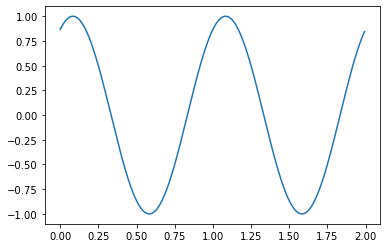

In [57]:
(t, g) = sine_wave(1, 300, 1/3 * np.pi, 2)
(t2, g2) = sine_wave(10, 300, 1/3 * np.pi, 20)
print(f"{len(g)}, {len(g2)}")

plt.plot(t, g)

# FFT

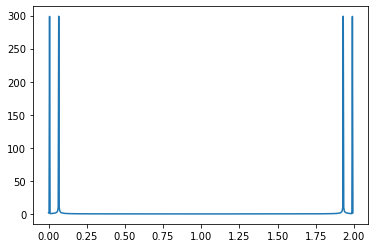

In [58]:
G = fft(g + g2, len(g))
plt.plot(t, np.abs(G))

# Binary Shift Phase Keying

In [59]:
# BPSK modulator at baseband
def bpsk_mod(data, L):
    s_bb = upfirdn(h=[1] * L, x=2 * data - 1, up = L)
    t = np.arange(start = 0, stop = len(data) * L)
    return (t, s_bb)

def bpsk_demod(r_bb, L):
    x = np.real(r_bb)
    x = np.convolve(x, np.ones(L))
    x = x[L-1:-1:L]
    return (x > 0).transpose()

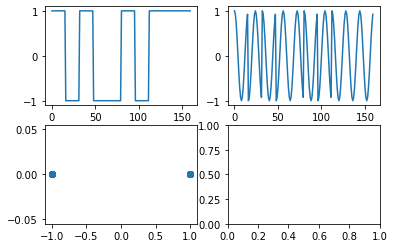

In [60]:
N = 10
L = 16
Fc = 800
Fs = Fc * L

data = np.random.randint(2, size=N)
# MOdulate
(t, s_bb) = bpsk_mod(data, L)
# Add to carrier
s = s_bb * np.cos(2 * np.pi * Fc * t / Fs)

# Demod
data_r = bpsk_demod(s_bb, L)

fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(t, s_bb)
ax[0, 1].plot(t, s)
ax[1, 0].plot(np.real(s_bb), np.imag(s_bb), 'o')

# AWGN

In [61]:
from numpy.random import standard_normal

In [62]:
def awgn(s, SNRdB, L=1):
    # Convert Noise to linear scale
    gamma = 10 ** (SNRdB/10)
    
    # Assumes s is a single dimension
    P = L * np.sum(np.abs(s) ** 2) / len(s)
    
    # Noise density
    N0 = P / gamma
    
    # Assumes real
    n = np.sqrt(N0/2) * standard_normal(s.shape)
    
    # Return original signal with added noise
    return s + n

Text(0.5, 1.0, 'With noise')

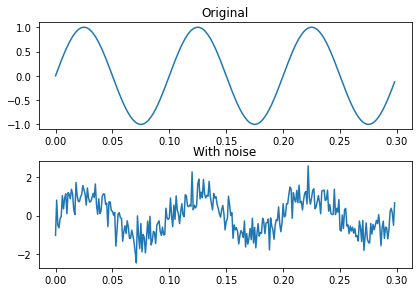

In [75]:
f = 10
L = 100 # Oversampling
fs = f * L
(t, sine) = sine_wave(10, fs, 0, 3)
sine_n = awgn(sine, 20, L=L)

fig, ax = plt.subplots(2, 1)
fig.tight_layout()
ax[0].plot(t, sine)
ax[0].set_title("Original")
ax[1].plot(t, sine_n)
ax[1].set_title("With noise")

## Reyleigh

In [64]:
def reyleigh_fading(N):
    """
    Generate reyleigh flat fading channel.
    Here the power distribution P_{av} = \sigma^2.
    
    Parameters:
        N: Number of samples to generate
    Returns (abs_h):
        abs_h: Reyleigh fading samples
    """
    
    h = 1/np.sqrt(2) * (standard_normal(N) + 1j * standard_normal(N))
    return np.abs(h)

Text(0.5, 1.0, 'Noise')

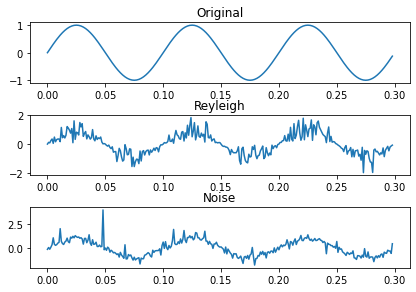

In [76]:
f = 10
L = 100 # Oversampling
fs = f * L
(t, sine) = sine_wave(10, fs, 0, 3)
rey = reyleigh_fading(len(sine))
faded = rey * sine

fig, ax = plt.subplots(3, 1)
fig.tight_layout()
ax[0].plot(t, sine)
ax[0].set_title("Original")
ax[1].plot(t, faded)
ax[1].set_title("Reyleigh")

# LETS ADD SOME NOISE
with_noise = awgn(faded, 30, L=L)
received = with_noise / rey
ax[2].plot(t, received)
ax[2].set_title("Noise")

# Rician

In [66]:
def rician_fading(kdB, N):
    """
    Generate Rician flat fading channel.
    
    Parameters:
        kdB: Rician K factor in dB
        N: Number of samples to generate
    """
    K = 10**(kdB/10)
    mean = np.sqrt(K / (2 * (K+1)))
    sigma = np.sqrt(1 / (2 * (K+1)))
    h = (sigma * standard_normal(N) + mean) + 1j * (sigma * standard_normal(N) + mean)
    return np.abs(h)

Text(0.5, 1.0, 'After')

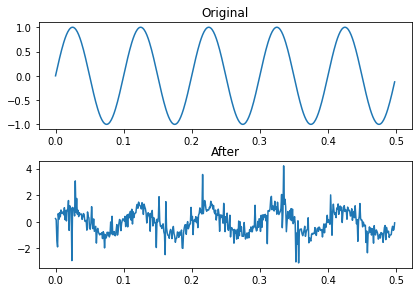

In [77]:
f = 10
L = 100 # Oversampling
fs = f * L
(t, sine) = sine_wave(10, fs, 0, 5)
rey = rician_fading(-10, len(sine))
faded = rey * sine
# Yo add the noise
with_noise = awgn(faded, 25, L=L)
received = with_noise / rey

fig, ax = plt.subplots(2, 1)
fig.tight_layout()
ax[0].plot(t, sine)
ax[0].set_title("Original")
ax[1].plot(t, received)
ax[1].set_title("After")